# Data preparation

In [ ]:
# If libraries are not installed
# !pip install torch
# !pip install torchsummary

In [93]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

In [82]:
df = pd.read_csv("vannkraft_data.txt", delimiter="\t")
# smaller dataset for testing
#df = df[:10000]
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y1,y2,y3,y4
0,0.611936,0.212342,0.005564,0.002857,0.008434,0.003076,0.89286,0.33198,0.82123,0.04170,1.00,0.73,1.00,0.99
1,0.250514,0.859806,0.521153,0.452315,0.305317,0.102649,0.89286,0.33198,0.82123,0.04170,0.00,1.00,0.00,0.00
2,0.150166,0.464592,0.132112,0.074232,0.154669,0.136805,0.89286,0.33198,0.82123,0.04170,0.00,0.01,0.00,0.00
3,0.316524,0.876727,0.001781,0.003298,0.008910,0.002462,0.14829,0.68229,0.16349,0.64823,0.00,0.00,0.00,0.00
4,0.303801,0.807405,0.050540,0.015564,0.065408,0.028042,0.14829,0.68229,0.16349,0.64823,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150025,0.214137,0.485883,0.011010,0.003721,0.012105,0.004806,0.44514,0.59493,0.20358,0.84718,0.00,0.00,0.00,0.00
150026,0.229117,0.275545,0.555918,0.161991,0.303823,0.206748,0.44514,0.59493,0.20358,0.84718,0.41,1.00,0.89,0.99
150027,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00,1.00,1.00,0.99
150028,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00,1.00,1.00,0.99


In [83]:
# Dataset has 10 inputs and four outputs
features = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
outputs = ['y1', 'y2', 'y3', 'y4']
X = df[features].values
y = df[outputs].values

In [84]:
seq_length = 100

# As I am working with LSTM, I need to create sequences for the model to learn and predict. A sequence length of 7 means the model uses 7 input samples to predict the 8th.
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, seq_length)

# Splitting the data. 80 % for training and 20 % for testing.
split_ratio = 0.8

train_size = int(len(X_seq) * split_ratio)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_test, y_test = X_seq[train_size:], y_seq[train_size:]

# Reshaping data. When scaling the data, we need a 2d input, so we remove one dimension.
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_reshaped)

# Reshaping data back to 3 dimensions. This is required for the LSTM model
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Converting to tensors, as this is expected from pytorch
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Defining train loaders with given batch sizes. This is how much data is trained at once. 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Architecture and training

In [85]:
# Simple LSTM network
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [86]:
# Hyperparameters. Num_layers are the amount of LSTM layers in the network. Hidden_size is the amount of units within the LSTM layers.
input_size = len(features)
output_size = len(outputs)
hidden_size = 64
num_layers = 2
learning_rate = 0.001
epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size).to(device)

# Mean squared error loss function, as we are dealing with continous outputs. Adam as optimizer, a pretty common optimizer to use.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
# Training loop. Given batch size is sent to the model, and a loss is calculated for each epoch with the difference between the prediction and the labels. Both training and eval is performed in this loop

train_losses = { "y1": [], "y2": [], "y3": [], "y4": [], "total": [] }
test_losses = { "y1": [], "y2": [], "y3": [], "y4": [], "total": [] }

for epoch in range(epochs):

    ## training the model
    model.train()
    epoch_loss = np.zeros(5)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)

        ## in this case I am computing the loss individually for each output, this is to see if some of the predictions are particularly hard
        loss_y1 = criterion(y_pred[:, 0], y_batch[:, 0])
        loss_y2 = criterion(y_pred[:, 1], y_batch[:, 1])
        loss_y3 = criterion(y_pred[:, 2], y_batch[:, 2])
        loss_y4 = criterion(y_pred[:, 3], y_batch[:, 3])
        loss_total = (loss_y1 + loss_y2 + loss_y3 + loss_y4) / 4
        
        loss_total.backward()
        optimizer.step()

        epoch_loss += np.array([loss_y1.item(), loss_y2.item(), loss_y3.item(), loss_y4.item(), loss_total.item()])
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses["y1"].append(avg_train_loss[0])
    train_losses["y2"].append(avg_train_loss[1])
    train_losses["y3"].append(avg_train_loss[2])
    train_losses["y4"].append(avg_train_loss[3])
    train_losses["total"].append(avg_train_loss[4])

    ## evaluating the model
    model.eval()
    epoch_loss = np.zeros(5)

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            
            loss_y1 = criterion(y_pred[:, 0], y_batch[:, 0])
            loss_y2 = criterion(y_pred[:, 1], y_batch[:, 1])
            loss_y3 = criterion(y_pred[:, 2], y_batch[:, 2])
            loss_y4 = criterion(y_pred[:, 3], y_batch[:, 3])
            loss_total = (loss_y1 + loss_y2 + loss_y3 + loss_y4) / 4

            epoch_loss += np.array([loss_y1.item(), loss_y2.item(), loss_y3.item(), loss_y4.item(), loss_total.item()])


    avg_test_loss = epoch_loss / len(test_loader)
    test_losses["y1"].append(avg_test_loss[0])
    test_losses["y2"].append(avg_test_loss[1])
    test_losses["y3"].append(avg_test_loss[2])
    test_losses["y4"].append(avg_test_loss[3])
    test_losses["total"].append(avg_test_loss[4])

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss[4]:.6f}, Test Loss: {avg_test_loss[4]:.6f}")

Epoch [1/30], Train Loss: 0.201033, Test Loss: 0.202548
Epoch [2/30], Train Loss: 0.200071, Test Loss: 0.202073
Epoch [3/30], Train Loss: 0.199887, Test Loss: 0.201702
Epoch [4/30], Train Loss: 0.199791, Test Loss: 0.201356
Epoch [5/30], Train Loss: 0.199737, Test Loss: 0.201081
Epoch [6/30], Train Loss: 0.199700, Test Loss: 0.201032
Epoch [7/30], Train Loss: 0.199666, Test Loss: 0.200805
Epoch [8/30], Train Loss: 0.199657, Test Loss: 0.200837
Epoch [9/30], Train Loss: 0.199655, Test Loss: 0.200654
Epoch [10/30], Train Loss: 0.199562, Test Loss: 0.200569
Epoch [11/30], Train Loss: 0.199737, Test Loss: 0.200537
Epoch [12/30], Train Loss: 0.199584, Test Loss: 0.201084
Epoch [13/30], Train Loss: 0.199664, Test Loss: 0.200522
Epoch [14/30], Train Loss: 0.199454, Test Loss: 0.200499
Epoch [15/30], Train Loss: 0.199462, Test Loss: 0.200441
Epoch [16/30], Train Loss: 0.199366, Test Loss: 0.200455
Epoch [17/30], Train Loss: 0.199317, Test Loss: 0.200459
Epoch [18/30], Train Loss: 0.199270, Tes

# Evaluation

In [95]:
print("Sample Predictions:")
y_pred_test = model(X_test_tensor.to(device)).cpu().detach().numpy()
for i in range(10):
    print(f"True: {y_test[i]}, Predicted: {y_pred_test[i]}")

Sample Predictions:
True: [1.   0.98 1.   0.94], Predicted: [0.3450465  0.3741382  0.35375673 0.34063807]
True: [0. 0. 0. 0.], Predicted: [0.35746118 0.4231515  0.3929879  0.40866134]
True: [0.97 0.79 0.97 0.94], Predicted: [0.31594226 0.45115495 0.35303462 0.37180454]
True: [0. 0. 0. 0.], Predicted: [0.35928738 0.43728742 0.3882059  0.40017685]
True: [0.64 0.76 0.85 0.45], Predicted: [0.33646697 0.41380417 0.36260992 0.3747435 ]
True: [1.   0.62 1.   0.99], Predicted: [0.37692317 0.3921326  0.39691624 0.38218126]
True: [0. 0. 0. 0.], Predicted: [0.37324405 0.3841397  0.39865595 0.37767965]
True: [0. 0. 0. 0.], Predicted: [0.38199073 0.38384768 0.3972127  0.38229784]
True: [0. 0. 0. 0.], Predicted: [0.37630436 0.50449544 0.41989285 0.43099192]
True: [1.   0.9  1.   0.99], Predicted: [0.28407755 0.43010145 0.3255505  0.34594736]


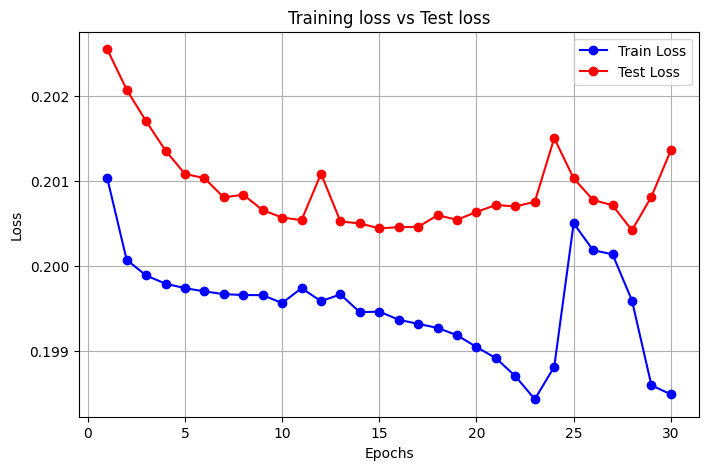

In [89]:
# Plot comparing training loss and test loss in average for the different outputs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses["total"], label="Train Loss", marker="o", color="blue")
plt.plot(range(1, epochs+1), test_losses["total"], label="Test Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss vs Test loss")
plt.legend()
plt.grid()
plt.show()

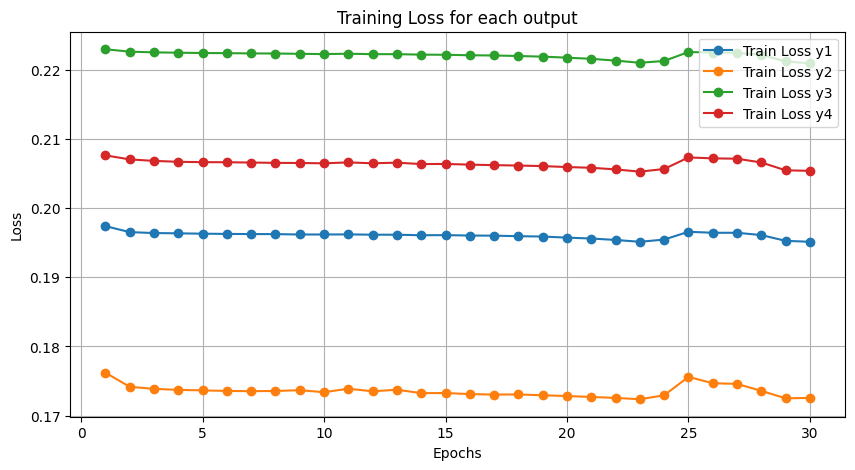

In [90]:
# Plot showing training loss for each individual output
plt.figure(figsize=(10, 5))
for key in ["y1", "y2", "y3", "y4"]:
    plt.plot(range(1, epochs+1), train_losses[key], marker="o", label=f"Train Loss {key}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for each output")
plt.legend()
plt.grid()
plt.show()

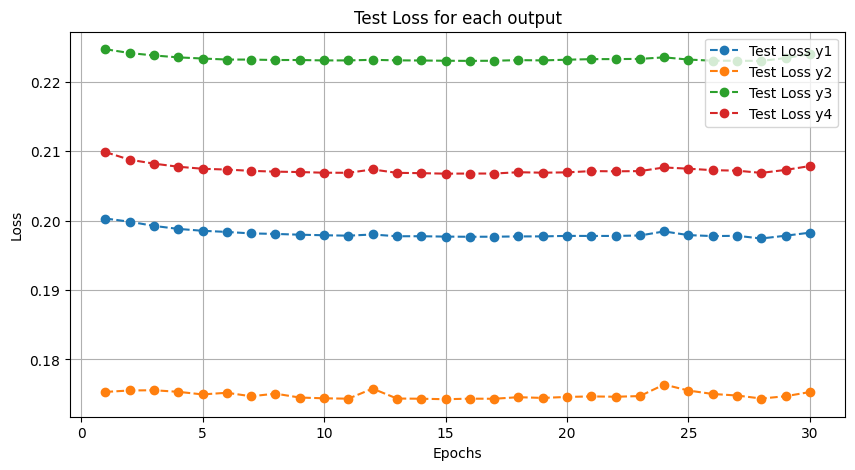

In [91]:
# Plot showing testing loss for each individual output
plt.figure(figsize=(10, 5))
for key in ["y1", "y2", "y3", "y4"]:
    plt.plot(range(1, epochs+1), test_losses[key], label=f"Test Loss {key}", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Loss for each output")
plt.legend()
plt.grid()
plt.show()

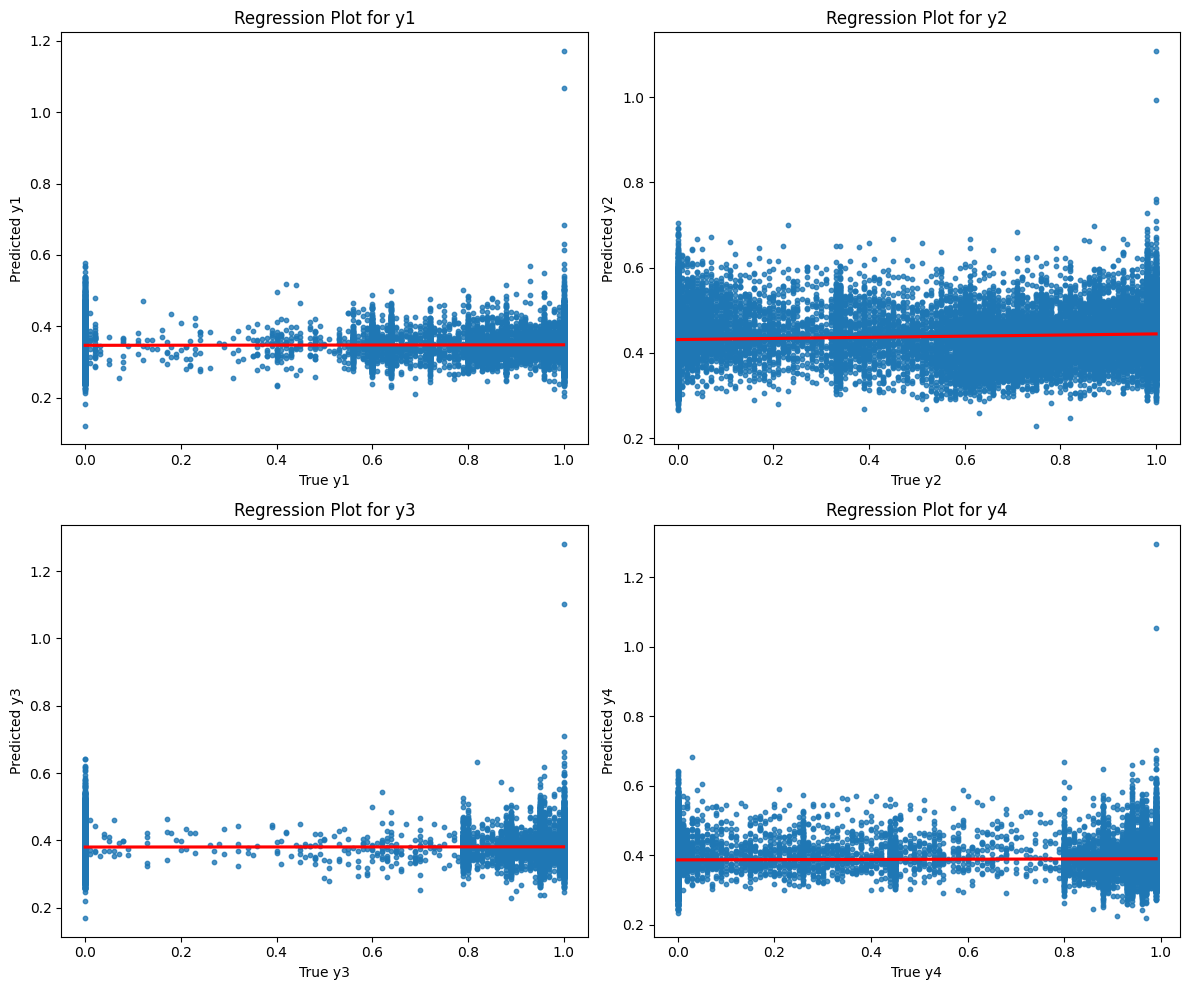

In [96]:
## Regression line between predictions and true labels. From the plot we can see that the model performs poorly on the dataset.

labels = ["y1", "y2", "y3", "y4"]

plt.figure(figsize=(12, 10))
for i, label in enumerate(labels):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=y_test[:, i], y=y_pred_test[:, i], scatter_kws={"s": 10}, line_kws={"color": "red"})
    plt.xlabel(f"True {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"Regression Plot for {label}")

plt.tight_layout()
plt.show()